In [ ]:
#| default_exp learner_new_callbacks

In [ ]:
#!pip install lovely-tensors

import lovely_tensors as lt
lt.monkey_patch()

In [ ]:
#Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
# seams to be issue not only related to torchaudio https://github.com/pytorch/pytorch/issues/46409
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from warnings import warn

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *

from fastprogress import progress_bar,master_bar

from torcheval.metrics import MulticlassAccuracy,Mean

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Learner

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dsd['train'].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [ ]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
bs = 1024
tds = dsd.with_transform(transformi)

In [ ]:
from miniai.learner import *

In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]),
 tensor[10] i64 x∈[0, 9] μ=3.300 σ=3.129 [9, 0, 0, 3, 0, 2, 7, 2, 5, 5])

In [ ]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

# Callbacks as generators with learner and local context, learner as dataclass

### How exception work in generators 

Below we will make a chian of generators, and experiment with the way traceback is presented
Generators can be chained with yield from, or multiple yeild statements, the former does not show 
the traceback so it is skipped here.

The issue with generators is that only exceptions thrown inside of the generator 
are capturing the traceback of the generators chain, and not the exception thrown in the with statement.
Which is problematic as callbacks often result in exception thrown from learner, and not from other callbacks or callback it self.

But the issue can be mitigated by running `import pdb; pdb.post_mortem()` in the except block of a with statement,
as then the tracback contains all the frames including the one from generators chain.

But this fortunately can be as well mitigated by using gen.throw with wrapped exception in RuntimeError
For some reason it only works if I wrap the exception, and not if I just pass the exception to gen.throw

The traceback object are somehow edited (not sure where) but the `gen.throw` statements re removed, but it is not that bad
providing that the code with gen.throw is simple enough so it does not need debugging.


In [ ]:
import traceback
@contextmanager
def context(cbs, inner_throw=False, raise_wrap=False, print_tb=False, **kwargs):
    try:
        print('before context manager')
        chain = iter(cbs)
        gen = next(chain)(chain, **kwargs)
        yield from gen
        print('after context manager')
    except Exception as e:
        if print_tb: traceback.print_exc()
        if inner_throw: 
            print(e.__traceback__, e.__traceback__.tb_next, 'name', e.__traceback__.tb_frame.f_code.co_name)
            gen.throw(RuntimeError, e, e.__traceback__) # for some reason the Type of exception need to be changed.

        if raise_wrap: raise RuntimeError('wrapper to show how debug will work', e)
        else: raise e

def cb1(chain, **kwargs):
    print('before cb1')
    yield from next(chain)(chain, **kwargs)
    print('after cb1')

def cb2(chain, **kwargs):
    print('before cb2')
    yield from next(chain)(chain, **kwargs)
    print('after cb2')
    
def cb3(chain, **kwargs):
    print('before cb3')
    yield from next(chain)(chain, **kwargs)
    print('after cb3')

def run(chain, ex_in_chain=False, **kwargs):
    print('run - last step')
    if ex_in_chain: raise Exception('error')
    yield None

cbs=[cb1, cb2, cb3, run]

with context(cbs=cbs,raise_wrap=True, print_tb=True) as ctx:
    print('with statement')


before context manager
before cb1
before cb2
before cb3
run - last step
with statement
after cb3
after cb2
after cb1
after context manager


In [ ]:
with context(cbs=cbs,inner_throw=True, print_tb=False) as ctx:
    print('with statement')
    1/0

before context manager
before cb1
before cb2
before cb3
run - last step
with statement
<traceback object> <traceback object> name context


RuntimeError: division by zero

In [ ]:
%debug

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2191738081.py(3)<module>()
      1 with context(cbs=cbs,inner_throw=True, print_tb=True) as ctx:
      2     print('with statement')
----> 3     1/0

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/1884909539.py(37)run()
     35     print('run - last step')
     36     if ex_in_chain: raise Exception('error')
---> 37     yield None
     38 
     39 cbs=[cb1, cb2, cb3, run]

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/1884909539.py(31)cb3()
     29 def cb3(chain, **kwargs):
     30     print('before cb3')
---> 31     yield from next(chain)(chain, **kwargs)
     32     print('after cb3')
     33 

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/1884909539.py(26)cb2()
     24 def cb2(chain, **kwargs):
     25     print('before cb2')
---> 26     yield from next(chain)(chain, **kwargs)
     27     print('after cb2')
     28 

> /var/folders/f2/nlr2kz4j2q542b5xz6z64

In [ ]:
with context(cbs=cbs,inner_throw=True, print_tb=True) as ctx:
    print('with statement')
    1/0


before context manager
before cb1
before cb2
before cb3
run - last step
with statement


ZeroDivisionError: division by zero

In [ ]:
%debug

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/3470928875.py(3)<module>()
      1 with context(cbs=cbs,inner_throw=True, print_tb=True) as ctx:
      2     print('with statement')
----> 3     1/0

*** Oldest frame


In [ ]:
with context(cbs=cbs,raise_wrap=True, print_tb=True) as ctx:
    print('with statement')
    1/0


before context manager
before cb1
before cb2
before cb3
run - last step
with statement


Traceback (most recent call last):
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2755306957.py", line 8, in context
    yield from gen
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2755306957.py", line 18, in cb1
    yield from next(chain)(chain, **kwargs)
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2755306957.py", line 23, in cb2
    yield from next(chain)(chain, **kwargs)
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2755306957.py", line 28, in cb3
    yield from next(chain)(chain, **kwargs)
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2755306957.py", line 34, in run
    yield None
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/3880792528.py", line 3, in <module>
    1/0
ZeroDivisionError: division by zero


RuntimeError: ('wrapper to show how debug will work', ZeroDivisionError('division by zero'))

In [ ]:
%debug

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2755306957.py(13)context()
     11         if inner_throw: gen.throw(e)
     12         if print_tb: traceback.print_exc()
---> 13         if raise_wrap: raise RuntimeError('wrapper to show how debug will work', e)
     14         else: raise e
     15 

> /opt/homebrew/Caskroom/miniforge/base/envs/miniai/lib/python3.10/contextlib.py(153)__exit__()
    151                 value = typ()
    152             try:
--> 153                 self.gen.throw(typ, value, traceback)
    154             except StopIteration as exc:
    155                 # Suppress StopIteration *unless* it's the same exception that

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/3880792528.py(1)<module>()
----> 1 with context(cbs=cbs,raise_wrap=True, print_tb=True) as ctx:
      2     print('with statement')
      3     1/0

*** Oldest frame


In [ ]:
with context(cbs=cbs,raise_wrap=False, print_tb=True, ex_in_chain=True) as ctx:
    print('with statement')

before context manager
before cb1
before cb2
before cb3
run - last step


Traceback (most recent call last):
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py", line 8, in context
    yield from gen
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py", line 18, in cb1
    yield from next(chain)(chain, **kwargs)
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py", line 23, in cb2
    yield from next(chain)(chain, **kwargs)
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py", line 28, in cb3
    yield from next(chain)(chain, **kwargs)
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py", line 33, in run
    if ex_in_chain: raise Exception('error')
Exception: error


Exception: error

In [ ]:
%debug

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py(33)run()
     31 def run(chain, ex_in_chain=False, **kwargs):
     32     print('run - last step')
---> 33     if ex_in_chain: raise Exception('error')
     34     yield None
     35 

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py(28)cb3()
     26 def cb3(chain, **kwargs):
     27     print('before cb3')
---> 28     yield from next(chain)(chain, **kwargs)
     29     print('after cb3')
     30 

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py(23)cb2()
     21 def cb2(chain, **kwargs):
     22     print('before cb2')
---> 23     yield from next(chain)(chain, **kwargs)
     24     print('after cb2')
     25 

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py(18)cb1()
     16 def cb1(chain, **kwargs):
     17     print('before cb1')
---> 18     yield from next(chain)(chain, **kwargs)
     19     print('after cb1')
 

In [ ]:
with context(cbs=cbs,raise_wrap=False, print_tb=True) as ctx:
    print('with statement')
    1/0

before context manager
before cb1
before cb2
before cb3
run - last step
with statement


Traceback (most recent call last):
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2622776919.py", line 7, in context
    yield from next(chain)(chain, reraise=False)
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2622776919.py", line 16, in cb1
    yield from next(chain)(chain, **kwargs)
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2622776919.py", line 21, in cb2
    yield from next(chain)(chain, **kwargs)
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2622776919.py", line 26, in cb3
    yield from next(chain)(chain, **kwargs)
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2622776919.py", line 32, in run
    yield None
  File "/var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/1937628265.py", line 3, in <module>
    1/0
ZeroDivisionError: division by zero


ZeroDivisionError: division by zero

In [ ]:
%debug

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/1937628265.py(3)<module>()
      1 with context(cbs=cbs,raise_wrap=False, print_tb=True) as ctx:
      2     print('with statement')
----> 3     1/0

*** Oldest frame


In [ ]:
@contextmanager
def context_no_try(cbs, **kwargs):
    print('before context manager')
    chain = iter(cbs)
    gen = next(chain)(chain, **kwargs)
    yield from gen
    print('after context manager')

with context_no_try(cbs=cbs):
    print('with statement')
    1/0

before context manager
before cb1
before cb2
before cb3
run - last step
with statement


ZeroDivisionError: division by zero

In [ ]:
%debug

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/2929159381.py(11)<module>()
      7     print('after context manager')
      8 
      9 with context_no_try(cbs=cbs):
     10     print('with statement')
---> 11     1/0

*** Oldest frame


In [ ]:
@contextmanager
def context_debug_on_ex(cbs, **kwargs):
    try:
        print('before context manager')
        chain = iter(cbs)
        gen = next(chain)(chain, **kwargs)
        yield from gen
        print('after context manager')
    except Exception as e:
        print('exception in context manager')
        import pdb; pdb.post_mortem()

with context_debug_on_ex(cbs=cbs):
    print('with statement')
    1/0

before context manager
before cb1
before cb2
before cb3
run - last step
with statement
exception in context manager
> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/1353566061.py(15)<module>()
     11         import pdb; pdb.post_mortem()
     12 
     13 with context_debug_on_ex(cbs=cbs):
     14     print('with statement')
---> 15     1/0

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py(34)run()
     32     print('run - last step')
     33     if ex_in_chain: raise Exception('error')
---> 34     yield None
     35 
     36 cbs=[cb1, cb2, cb3, run]

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py(28)cb3()
     26 def cb3(chain, **kwargs):
     27     print('before cb3')
---> 28     yield from next(chain)(chain, **kwargs)
     29     print('after cb3')
     30 

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_11899/481506535.py(23)cb2()
     21 def cb2(chain, **kwargs):
     22     print('bef

### Implementation

In [ ]:
import typing
import dataclasses

In [ ]:
def last_in_a_chain(*args, **kwargs):
    yield None
class Callback2():
    order = 0
@dataclasses.dataclass
class DeviceCB2(Callback2):
    device: str|torch.device = def_device
    def fit(self, chain, learn, l): 
        learn.model.to(self.device)
        yield from next(chain)(chain, learn, l)
    
    def batch(self, chain, learn, l): 
        l.batch = to_device(l.batch, device=self.device)
        yield from next(chain)(chain, learn, l) # try to remove this for nice error but only on first callback :(

In [ ]:
class StateDict(dict):
    def __getattr__(self, k): # hasattr works
        try: return self[k] 
        except: raise AttributeError(k)
    def __setattr__(self, k: str, v: typing.Any) -> None:
        self[k]=v
hasattr(StateDict(), 'a')

False

In [ ]:
@dataclasses.dataclass
class Learner:
    model: nn.Module
    dls: DataLoaders
    loss_func: typing.Callable
    lr: float|torch.Tensor
    cbs: typing.List[Callback2]
    opt_func: typing.Callable = optim.SGD
    l: StateDict = dataclasses.field(default_factory=StateDict)
    def __post_init__(self):
        self.cbs = sorted(self.cbs, key=attrgetter('order'))
    
    @contextmanager
    def callback_ctx(self, nm):
        cbs = []
        try:
            chain = iter([getattr(cb,nm) for cb in self.cbs if hasattr(cb, nm)] + [last_in_a_chain])
            n = next(chain)
            gen = n(chain=chain, learn=self, l=self.l)
            assert gen is not None, f'Your callback {n} need to have `yield from self.next(chain, learn, l)`'
            yield from gen
        except globals()[f'Cancel{nm.title()}Exception']: pass
        except Exception as e:
            if e.__traceback__.tb_next is None: raise
            gen.throw(RuntimeError, e, e.__traceback__) # To make the exception appear in chain of callbacks
        finally: 
            #list(gen)
            ...

    def one_epoch(self, train):
        self.model.train(train)
        self.l.dl = self.dls.train if train else self.dls.valid
        with self.callback_ctx('epoch'):
            for self.l.iter,self.l.batch in enumerate(self.l.dl):
                with self.callback_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs):
        self.l.n_epochs = n_epochs
        self.l.epochs = range(n_epochs)
        self.l.opt = self.opt_func(self.model.parameters(), self.lr)
        with self.callback_ctx('fit'):
            for self.l.epoch in self.l.epochs:
                self.one_epoch(True)
                with torch.no_grad(): self.one_epoch(False)

    def predict(self): self.l.preds = self.model(self.l.batch[0])
    def get_loss(self): self.l.loss = self.loss_func(self.l.preds, self.l.batch[1])
    def backward(self): self.l.loss.backward()
    def step(self): self.l.opt.step()
    def zero_grad(self): self.l.opt.zero_grad()

    def reset(self): self.l.clear()

In [ ]:
cbs = [DeviceCB2('mps')]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

In [ ]:
# Shorter callback system with inheritance

In [ ]:
def cb_safeguard(f, name):
    def _inner(*args, **kwargs):
        gen = f(*args, **kwargs)
        assert gen is not None, f'Your callback {f} need to `yield from super().{name}(learn, l)`'
        return gen
    return _inner

class CBChainEnd():
    def end(self, learn, l): yield None
    def __getattr__(self, name): return self.end
    
class CallbackS():
    order = 0
    next:'CallbackS' = CBChainEnd()
    def fit(self, learn, l): yield from cb_safeguard(self.next.fit, 'fit')(learn, l)
    def epoch(self, learn, l): yield from cb_safeguard(self.next.epoch, 'epoch')(learn, l)
    def batch(self, learn, l): yield from cb_safeguard(self.next.batch, 'batch')(learn, l)
    
class CallbackChain(CallbackS):
    def __init__(self, cbs):
        cbs = sorted(cbs, key=attrgetter('order'))
        n = CBChainEnd()
        for cb in cbs: 
            cb.next = n
            n = cb
        self.next = n

In [ ]:
class BrokenCallback(CallbackS):
    def fit(self, learn, l): 
        print("do some action and don't yield")
cb = CallbackChain([BrokenCallback()])
try: list(cb.fit(None, None))
except AssertionError as e: print(e)

do some action and don't yield
Your callback <bound method BrokenCallback.fit of <__main__.BrokenCallback object>> need to `yield from super().fit(learn, l)`


In [ ]:
@dataclasses.dataclass
class DeviceCB2(CallbackS):
    device: str|torch.device = def_device
    def fit(self, learn, l): 
        learn.model.to(self.device)
        yield from super().fit(learn, l)
    
    def batch(self, learn, l): 
        l.batch = to_device(l.batch, device=self.device)
        # test what happens if we don't yield in the middle of a chain
        yield from super().batch(learn, l)

In [ ]:
list(DeviceCB2('mps').fit(learn, None))

[None]

In [ ]:
@dataclasses.dataclass
class Learner:
    model: nn.Module
    dls: DataLoaders
    loss_func: typing.Callable
    lr: float|torch.Tensor
    cbs: typing.List[CallbackS]
    opt_func: typing.Callable = optim.SGD
    l: StateDict = dataclasses.field(default_factory=StateDict)
    def __post_init__(self):
        self.entry = CallbackChain(self.cbs)

    @contextmanager
    def callback_ctx(self, nm):
        cbs = []
        try:
            gen = getattr(self.entry, nm)(learn=self, l=self.l)
            yield from gen
        except globals()[f'Cancel{nm.title()}Exception']: list(gen) # do the after callbacks
        except Exception as e:
            if e.__traceback__.tb_next is None: raise
            gen.throw(RuntimeError, e, e.__traceback__) # To make the exception appear in chain of callbacks

    def one_epoch(self, train):
        self.model.train(train)
        self.l.dl = self.dls.train if train else self.dls.valid
        with self.callback_ctx('epoch'):
            for self.l.iter,self.l.batch in enumerate(self.l.dl):
                with self.callback_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs):
        self.l.n_epochs = n_epochs
        self.l.epochs = range(n_epochs)
        self.l.opt = self.opt_func(self.model.parameters(), self.lr)
        with self.callback_ctx('fit'):
            for self.l.epoch in self.l.epochs:
                self.one_epoch(True)
                with torch.no_grad(): self.one_epoch(False)

    def predict(self): self.l.preds = self.model(self.l.batch[0])
    def get_loss(self): self.l.loss = self.loss_func(self.l.preds, self.l.batch[1])
    def backward(self): self.l.loss.backward()
    def step(self): self.l.opt.step()
    def zero_grad(self): self.l.opt.zero_grad()

    def reset(self): self.l.clear()

In [ ]:
cbs = [DeviceCB2('mps')]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

In [ ]:
class MetricsCB2(CallbackS):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def fit(self, learn, l):
        l.metrics = self
        yield from super().fit(learn, l)
    
    def epoch(self, learn, l): 
        for o in self.all_metrics.values(): o.reset() 
        yield from super().epoch(learn, l)
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = l.epoch
        log['train'] = learn.model.training
        self._log(log)

    def batch(self, learn, l):
        yield from super().batch(learn, l)
        if not hasattr(l, 'preds'): return
        x,y = to_cpu(l.batch)
        for m in self.metrics.values(): m.update(to_cpu(l.preds), y)
        self.loss.update(to_cpu(l.loss), weight=len(x))

In [ ]:
metrics = MetricsCB2(accuracy=MulticlassAccuracy())
cbs = [DeviceCB2(), metrics]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

{'accuracy': '0.606', 'loss': '1.163', 'epoch': 0, 'train': True}
{'accuracy': '0.704', 'loss': '0.801', 'epoch': 0, 'train': False}


In [ ]:
class CompletionCB(CallbackS):
    def fit(self, *_):
        self.count = 0
        yield from super().fit(*_)
        print(f'Completed {self.count} batches')
    def batch(self, *_): 
        yield from super().batch(*_)
        self.count += 1

In [ ]:
cb = CompletionCB()
fitcb = cb.fit(None, None)
next(fitcb) # run the before
list(cb.batch(None,None)) # run the batch after and before
list(cb.batch(None,None)) # run the batch after and before
list(cb.batch(None,None)) # run the batch after and before
list(fitcb); # run the rest of fit callback (after_fit)

Completed 3 batches


In [ ]:
#|export
@dataclasses.dataclass
class ProgressCB2(CallbackS):
    order = MetricsCB2.order+1
    plot: bool = False
    def fit(self, learn, l):
        l.epochs = self.mbar = master_bar(l.epochs)
        if hasattr(l, 'metrics'): l.metrics._log = self._log
        self.losses = []
        yield from super().fit(learn, l)
    def _log(self, d): self.mbar.write(str(d))
    def epoch(self, learn, l): 
        l.dl = progress_bar(l.dl, leave=False, parent=self.mbar)
        yield from super().epoch(learn, l)
    def batch(self, learn, l):
        yield from super().batch(learn, l)
        if not hasattr(l, 'loss'): return
        l.dl.comment = f'{l.loss:.3f}'
        if self.plot and hasattr(l, 'metrics') and learn.model.training:
            self.losses.append(l.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

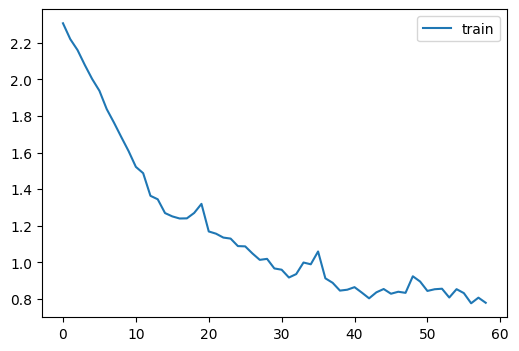

{'accuracy': '0.612', 'loss': '1.173', 'epoch': 0, 'train': True}
{'accuracy': '0.695', 'loss': '0.878', 'epoch': 0, 'train': False}


In [ ]:
metrics = MetricsCB2(accuracy=MulticlassAccuracy())
cbs = [DeviceCB2(), metrics, ProgressCB2(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

# Callbacks as inheritance , learner as dataclass

In [ ]:
class LoopTst:
    val=[]
    def fit(self, throw=False):
        print('fit base', self.val)
        if throw: raise Exception('test')

class ToDeviceLoop(LoopTst):
    def fit(self, **kw):
        self.val += ['todevice'];
        print('before_fit todevice', self.val)
        super().fit(**kw)
        print('after_fit todevice', self.val)
        self.val.remove('todevice')
        
class MetricsLoop(LoopTst):
     def fit(self, **kw):
        self.val += ['metrics'];
        print('before_fit metrics', self.val)
        super().fit(**kw)
        print('after_fit metrics', self.val)
        self.val.remove('metrics')

class Progress(MetricsLoop):
    def fit(self, **kw):
        self.val += ['progress'];
        print('before_fit progress', self.val)
        super().fit(**kw)
        print('after_fit progress', self.val)
        self.val.remove('progress')

class CompletionCB(Callback):
    def fit(self, **kw):
        self.val += ['completion'];
        print('before_fit progress', self.val)
        super().fit(**kw)
        print('after_fit progress', self.val)
        self.val.remove('completion')

class ExLoop(ToDeviceLoop, Progress, MetricsLoop, LoopTst):
    pass

ExLoop().fit()

before_fit todevice ['todevice']
before_fit progress ['todevice', 'progress']
before_fit metrics ['todevice', 'progress', 'metrics']
fit base ['todevice', 'progress', 'metrics']
after_fit metrics ['todevice', 'progress', 'metrics']
after_fit progress ['todevice', 'progress']
after_fit todevice ['todevice']


In [ ]:
ExLoop().fit(throw=True)

before_fit todevice ['todevice']
before_fit progress ['todevice', 'progress']
before_fit metrics ['todevice', 'progress', 'metrics']
fit base ['todevice', 'progress', 'metrics']


Exception: test

In [ ]:
## How to make such type dynamically?

In [ ]:
ExLoop2 = type('exloop', (ToDeviceLoop, Progress), {})
ExLoop2().fit()

before_fit todevice ['todevice', 'progress', 'metrics', 'todevice']
before_fit progress ['todevice', 'progress', 'metrics', 'todevice', 'progress']
before_fit metrics ['todevice', 'progress', 'metrics', 'todevice', 'progress', 'metrics']
fit base ['todevice', 'progress', 'metrics', 'todevice', 'progress', 'metrics']
after_fit metrics ['todevice', 'progress', 'metrics', 'todevice', 'progress', 'metrics']
after_fit progress ['todevice', 'progress', 'todevice', 'progress', 'metrics']
after_fit todevice ['todevice', 'todevice', 'progress', 'metrics']


The prons of mutliple inheritance are:
- uses standard python so it is easy for linters to figure out what is going on,
- is easy to detect lack od `super().call('xxx')` as it is visually distinct,
- one can depend on other callbacks so that they are included automatically, in correct order. 
- linters will tell you if your base class lost some members you depended upon

The cons are:
- Multiple inheritance is hard, 
- if you provide list of Callbacks in wrong order you will get an error eg: (MetricsLoop, Progress) vs (Progress, MetricsLoop)  
- Parameters are shared and can clash, [@dataclasses does not help]

In [ ]:
class BaseLoop:
    a: int = 1
class SecondLoop(BaseLoop):
    b: int = 2
class ThirdLoop(BaseLoop):
    b: str = 'test'
    
t = type('exloop', (SecondLoop, ThirdLoop), {})
t().b

2

In [ ]:
@dataclass
class BaseLoop:
    a: int = 1
@dataclass
class SecondLoop(BaseLoop):
    b: int = 2
@dataclass
class ThirdLoop(BaseLoop):
    b: str = 'test'
    
t = dataclass(type('exloop', (SecondLoop, ThirdLoop), {}))
t()

exloop(a=1, b=2)

In [ ]:
# Alternative approach to achieve similar stacktrace is use a chain of callbacks



In [ ]:
class LoopBase:
    cbs_chain: typing.Union['CBChain','LoopBase']
    def batch(self, batch_throw=False, **kw):
        print('batch base')
        if batch_throw: raise Exception('test')
        
    def fit(self, throw=False, **kw):
        print('fit base')
        if throw: raise Exception('test')
        self.cbs_chain.batch(**kw)
        
class CBChain():
    next:'CBChain'
    @classmethod
    def with_next(cls, next) -> 'CBChain': 
        self = cls()
        self.next = next
        return self
    def batch(self, **kw):
        self.next.batch(**kw)
    
    def fit(self, **kw):
        self.next.fit(**kw)

class ToDeviceLoop(CBChain):
    def fit(self, **kw):
        print('before_fit todevice')
        super().fit(**kw)
        print('after_fit todevice')
        
class MetricsLoop(CBChain):
     def fit(self, **kw):
        print('before_fit metrics')
        super().fit(**kw)
        print('after_fit metrics')

class Progress(CBChain):
    def batch(self, **kw):
        print('before batch progress')
        try:
            return super().batch(**kw)
        finally:
            print('after batch progress')
    def fit(self, **kw):
        print('before_fit progress')
        super().fit(**kw)
        print('after_fit progress')

class CompletionCB(CBChain):
    def fit(self, **kw):
        print('before_fit progress')
        super().fit(**kw)
        print('after_fit progress')


def build(*callbacks):
    # for simplicty assuming the last callback
    n = base = LoopBase()
    for c in reversed(callbacks):
        c.next = n
        n = c
    base.cbs_chain = CBChain.with_next(n)
    return base.cbs_chain 

loop = build(ToDeviceLoop(), Progress(), MetricsLoop())
loop.fit()

before_fit todevice
before_fit progress
before_fit metrics
fit base []
before batch progress
batch base []
after batch progress
after_fit metrics
after_fit progress
after_fit todevice


In [ ]:
loop.fit(batch_throw=True)

before_fit todevice
before_fit progress
before_fit metrics
fit base []
before batch progress
batch base []
after batch progress


Exception: test

In [ ]:
import dataclasses



@dataclasses.dataclass
class Learner():
    model: nn.Module
    dls: DataLoaders
    loss_func: typing.Callable
    lr: float|torch.Tensor
    opt_func: typing.Callable = optim.SGD

    def new(*args, cbs=[], name='ModLearn', **kwargs):
        if cbs:
            cls = type(name, tuple(map(CallbackWrap.wrap, cbs)), {})
        else:
            cls = Learner
        return cls(*args, **kwargs)
 
    
    def do_batch(self):
        self.compute_preds()
        self.compute_loss()
        if self.model.training:
            self.backward()
            self.step()
            self.zero_grad()
    
    def setup_epoch(self, train: bool):
        self.model.train(train)
        self.data_loader = self.dls.train if train else self.dls.valid
                                             
    def do_epoch(self, train: bool):
        self.setup_epoch(train)
        for self.iter,self.batch in enumerate(self.data_loader):
            self.do_batch()
    
    def setup_fit(self, n_epochs, lr):
        self.n_epochs = n_epochs
        self.epochs = range(self.n_epochs)
        self.opt = learn.opt_func(learn.model.parameters(), lr)
    
    def fit(self, n_epochs, lr=None):
        self.setup_fit(n_epochs, lr)
        for self.epoch in self.epochs:
            self.do_epoch(True)
            with torch.no_grad(): 
                self.do_epoch(True)

    def compute_preds(self): self.preds = self.model(self.batch[0])
    def compute_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()
    
class CallbackWrap(Learner):
    cb: 'Callback'
    
    @staticmethod 
    def wrap(callback):
        if isinstance(callback, Callback):
            return type(callback.__class__.__name__, (CallbackWrap,), {'cb': callback})
        else:
            return callback
        
        
    def do_batch(self):
        super().do_batch()
        self.callback('after_batch')
    
    def setup_epoch(self, train: bool):
        super().setup_epoch(train)
        self.callback('before_epoch')
    
    def do_epoch(self, train: bool):
        super().do_epoch(train)
        self.callback('after_epoch')
    
    def setup_fit(self, n_epochs, lr):
        super().setup_fit(n_epochs, lr)
        self.callback('before_fit')
        
    def fit(self, n_epochs, lr=None):
        super().fit(n_epochs, lr)
        self.callback('after_fit')
    
    def callback(self, name):
        self.cb.learn = self
        if hasattr(self.cb, name):
            getattr(self, name)()

cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner.new(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2, lr=0.2)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

False

In [ ]:
# Failed attempt at making it work with generators

In [ ]:
@dataclass
class Callback2():
    order = 0


In [ ]:
def run_cbs2(cbs, phase, **kwargs):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, phase, None)
        if method is not None: yield method(**kwargs)

In [ ]:
class StateDict(dict):
    def __getattr__(self, k): return self[k]
    def __setattr__(self, k: str, v: typing.Any) -> None:
        self[k]=v

import weakref
class Loop():
    def _one_batch(self, learn):
        self.compute_preds(learn)
        self.compute_loss(learn)
        if learn.model.training:
            self.backward(learn)
            self.step(learn)
            self.zero_grad(learn)
    
    def data_loader(self, learn): 
        return learn.dls.train if learn.model.training else learn.dls.valid
    
    def _one_epoch(self, learn):
        for self.iter,self.batch in enumerate(self.data_loader(learn)):
            self._one_batch(learn)
    
    def epochs(self, learn):
        return range(self.n_epochs) 
    
    def _setup_fit(self, learn, n_epochs, lr):
        self.n_epochs = n_epochs
        self.opt = learn.opt_func(learn.model.parameters(), lr)
    
    def _fit(self, learn):
        for self.epoch in self.epochs(learn):
            learn.model.train(True)
            self._one_epoch(learn)
            with torch.no_grad(): 
                learn.model.train(False)
                self._one_epoch(False)
                
    def fit(self, learn, n_epochs, lr=None):
        self._setup_fit(learn, n_epochs, lr)
        self._fit(learn)

    def compute_preds(self, learn): self.preds = learn.model(self.batch[0])
    def compute_loss(self, learn): self.loss = learn.loss_func(self.preds, self.batch[1])
    def backward(self, learn): self.loss.backward()
    def step(self, learn): self.opt.step()
    def zero_grad(self, learn): self.opt.zero_grad()

import dataclasses        
@dataclass(frozen=True)
class Learner():
    model: nn.Module
    dls: DataLoaders
    loss_func: typing.Callable
    lr: float|torch.Tensor
    cbs: typing.List[Callback]
    opt_func: typing.Callable = optim.SGD
    ctx: StateDict = dataclasses.field(default_factory=StateDict)
    
    def reset(self):
        self.ctx.clear()

    def fit(self, n_epochs):
        if 'loop' not in self.ctx: self.ctx.loop = Loop()
        self.ctx.loop.fit(self, n_epochs)
    

In [ ]:
@dataclass
class DeviceCB2(Callback2):
    device: str|torch.device = def_device
    def fit(self, learn, l): 
        learn.model.to(self.device)
        yield
    
    def batch(self, learn, l): 
        yield dict(batch=to_device(l.batch, device=self.device))

In [ ]:
cbs = [DeviceCB2()]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

In [ ]:
#|export
class MetricsCB2(Callback2):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def fit(self, learn, l):
        yield dict(metrics=self)
    
    def epoch(self, learn, l): 
        for o in self.all_metrics.values(): o.reset() 
        yield # to collect more data with batch hook
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = l.epoch
        log['train'] = learn.model.training
        self._log(log)

    def batch(self, learn, l):
        yield # do the work
        if not hasattr(l, 'preds'): return
        x,y = to_cpu(l.batch)
        for m in self.metrics.values(): m.update(to_cpu(l.preds), y)
        self.loss.update(to_cpu(l.loss), weight=len(x))

In [ ]:
metrics = MetricsCB2(accuracy=MulticlassAccuracy())
cbs = [DeviceCB2(), metrics, ProgressCB2(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

AttributeError: 'bool' object has no attribute 'model'

In [ ]:
metrics = MetricsCB2(accuracy=MulticlassAccuracy())
cbs = [DeviceCB2(), metrics]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

{'accuracy': '0.601', 'loss': '1.178', 'epoch': 0, 'train': True}
{'accuracy': '0.696', 'loss': '0.810', 'epoch': 0, 'train': False}


In [ ]:
class CompletionCB(Callback):
    def fit(self, **_): 
        print('test')
        self.count = 0
        yield
        print(f'Completed {self.count} batches')
    def batch(self, **_): 
        yield 
        self.count += 1

In [ ]:
cbs = [CompletionCB()]
fit = [a.send(None) for a in run_cbs2(cbs, 'fit')]
list(map(list, run_cbs2(cbs, 'batch')))
list(fit)

test


[None]

In [ ]:
#|export
@dataclass
class ProgressCB2(Callback2):
    order = MetricsCB2.order+1
    plot: bool = False
  
    def fit(self, learn, l):
        self.mbar = master_bar(l.epochs)
        if hasattr(l, 'metrics'): l.metrics._log = self._log
        self.losses = []
        yield dict(epochs=self.mbar)
        
    def _log(self, d): self.mbar.write(str(d))
    def epoch(self, learn, l): 
        yield dict(dl=progress_bar(l.dl, leave=False, parent=self.mbar))
        
    def batch(self, learn, l):
        yield
        if not hasattr(l, 'loss'): return
        if self.plot and hasattr(l, 'metrics') and learn.model.training:
            self.losses.append(l.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])
        l.dl.comment = f'{l.loss:.3f}'
        # unable to access second level, yield dict(dl.comment = f'{l.loss:.3f}')

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

AttributeError: 'bool' object has no attribute 'model'

## TrainLearner and MomentumLearner

In [ ]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [ ]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


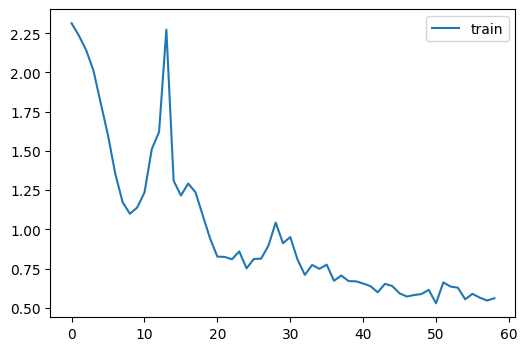

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


In [ ]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## LRFinderCB

In [ ]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self):
        if not self.training: raise CancelEpochException()
        self.lrs.append(self.opt.param_groups[0]['lr'])
        loss = to_cpu(self.learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in self.opt.param_groups: g['lr'] *= self.lr_mult

In [ ]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), ProgressCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


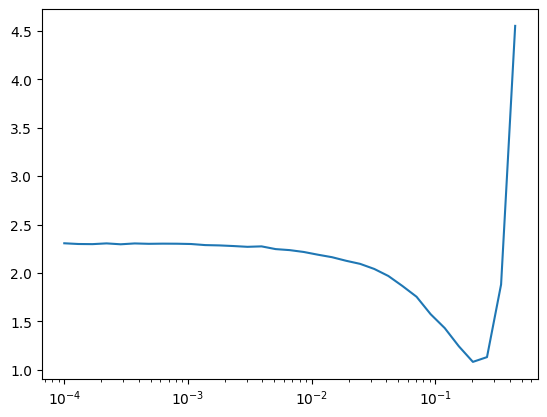

In [ ]:
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

In [ ]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

[ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)

In [ ]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self):
        self.sched = ExponentialLR(self.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self):
        if not self.training: raise CancelEpochException()
        self.lrs.append(self.opt.param_groups[0]['lr'])
        loss = to_cpu(self.learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*self.max_mult: raise CancelFitException()
        self.sched.step()

    def after_fit(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


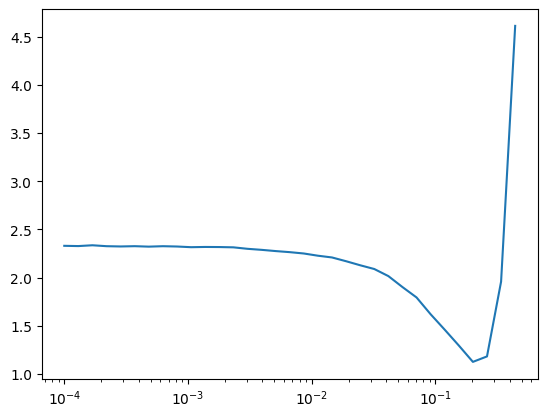

In [ ]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), ProgressCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()